# Pytorch Transfer learning


## Contents

* Load data
* General functions to train and visualize
* Transfer learning: feature extractor (Inception v3)
* Train and evaluate

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn

import time
import copy

In [2]:
torch.cuda.is_available()

True

## 1. Load data

Here we use [**torchvision.datasets.ImageFolder**](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) to load our data.

It is A generic data loader where the images are arranged in this way:**

>root/dog/xxx.png
>
>root/cat/123.png



In [3]:
# Another way to copy the pretrained models to the cache directory (~/.torch/models) where PyTorch is looking for them.
# From https://www.kaggle.com/pvlima/use-pretrained-pytorch-models#Transfer-learning-in-kernels-with-PyTorch
import os
from os import listdir, makedirs, getcwd, remove
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.torch'))

if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/pretrained-pytorch-models/* ~/.torch/models/
!ls ~/.torch/models

densenet161-17b70270.pth	  resnet50-19c8e357.pth
inception_v3_google-1a9a5a14.pth  squeezenet1_0-a815701f.pth
resnet18-5c106cde.pth		  squeezenet1_1-f364aa15.pth


In [4]:
import torchvision
from torchvision import datasets, transforms
import os
import torch

#### Define transformations for training and validation sets, including resizing, center cropping, 


In [5]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(325),      # 325 x 325 pixels
        transforms.CenterCrop(299),  # Inception v3 requires this size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pretrained models
    ]),
    'val': transforms.Compose([  # Same transformations applied to validation set
        transforms.Resize(325),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Load images from folders, applying the transformations for each dataset (train and val).

In [6]:
data_dir = "../input/dogs-vs-cats/dataset/dataset"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, name), data_transforms[x])
                  for x, name in [['train', "training_set"], ['val', "test_set"]]}
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 8000
    Root Location: ../input/dogs-vs-cats/dataset/dataset/training_set
    Transforms (if any): Compose(
                             Resize(size=325, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(299, 299))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None, 'val': Dataset ImageFolder
    Number of datapoints: 2000
    Root Location: ../input/dogs-vs-cats/dataset/dataset/test_set
    Transforms (if any): Compose(
                             Resize(size=325, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(299, 299))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None}


#### Create DataLoaders to load images in batches for training and validation.


In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=64, 
                                              shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val']}
print(dataloaders)
len(dataloaders['train'])

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f9456b8b668>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f9456b8bb70>}


125

#### Get the size and the class names

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 8000, 'val': 2000}
['cats', 'dogs']


#### Visualize a few images

In [9]:
import numpy as np  
import matplotlib.pyplot as plt 
plt.ion()  #interactive mode

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # transpose it to (height, width, channels)
    
    # De-normalize the image
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    # Clip the values to be between 0 and 1 for valid image display
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title) # set the title of the plot
    
    plt.pause(0.001) # Briefly pause to ensure the plot gets updated


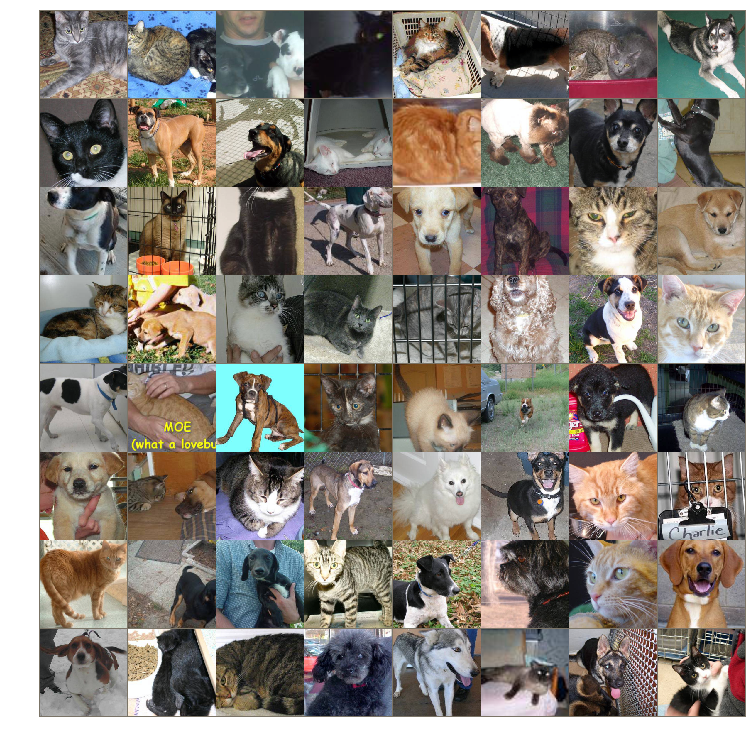

In [10]:
inputs, classes = next(iter(dataloaders['train'])) # Get a batch of training data
out = torchvision.utils.make_grid(inputs) # Create a grid of images from the batch

plt.figure(figsize=(13, 13))
plt.axis('off')
imshow(out)

#imshow(out, title=[class_names[x] for x in classes]) # display the class names

## 2. General functions to train and visualize

Here we use a general function to train a model. It includes:

* Scheduling the learning rate
* Saving the best model

We use [*torch.optim.lr_scheduler*](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). It provides several methods to adjust the learning rate based on the number of epochs. Our function parameter `scheduler` is an object from it.

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, is_inception=False):
    since = time.time()  # Store the start time to calculate the total training time.
   
    best_model_wts = copy.deepcopy(model.state_dict())  # Save initial weights to track the best model based on accuracy. (because python copy by refrence)

    best_acc = 0.0
    for epoch in range(num_epochs):
        # Print the current epoch number for tracking.
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:

            if phase == 'train':
                scheduler.step()                 # Step the learning rate scheduler at the beginning of the training phase.
                model.train()                    # Set the model to training mode (enables dropout and batch normalization).
            else:
                model.eval()                     # Set to evaluation mode (disables dropout and batch normalization).

            running_loss = 0.0
            running_corrects = 0                 #to track loss and true predicted

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)       # Send the data to the device.

                optimizer.zero_grad()            # Reset the gradients to prevent accumulation from previous batches.

                with torch.set_grad_enabled(phase == 'train'):
                    # Enable gradient calculation only for the training phase.
                    if is_inception and phase == 'train':
                        # Handle the special case for the Inception model, which uses an auxiliary output during training.
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)   # Calculate the loss

                    _, preds = torch.max(outputs, 1)        # Get the class predictions (the max in dimension 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                    # Backpropagate the loss and update the model parameters in the training phase.

                running_loss += loss.item() * inputs.size(0)              # Accumulate the total loss for the current phase.
                running_corrects += torch.sum(preds == labels.data)       # Accumulate the number of correct predictions.

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())    # Save the model weights as the best model.

        print()

    time_elapsed = time.time() - since                                # Calculate the total training time.
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)                             # Load the best model weights 
    return model


### Visualizing the model predictions

A generic function to display predictions for a few images.

In [12]:
def visualize_model(model, num_images=6):
    
    # Save the model's current training mode (train/eval)
    was_training = model.training
    model.eval()                     # Set to evaluation mode (disables dropout, batchnorm, etc.)
    images_so_far = 0                # Counter for how many images have been displayed
    fig = plt.figure()  

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Loop through batches of validation data
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)  
            labels = labels.to(device)            # Move to the correct device

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)      # Get the predicted class with highest score

            # Loop through each image in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1  
                ax = plt.subplot(num_images//2, 2, images_so_far)    # Create subplot for the current image
                ax.axis('off')  
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))         # Set the title to the predicted class name
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)             # Restore the model's original mode
                    return                                     # Stop if we've reached the desired number of images
        
        # Restore the model's original mode after finishing visualization
        model.train(mode=was_training)


## 3. Transfer learning: feature extractor

Here we use **Inception v3** as a fixed feature extractor.

Here, we need to freeze all the network except the final layer. We need to set `requires_grad == False` to freeze the parameters so that the gradients are not computed in `backward()`.

### Inception v3

Inception v3 was first described in [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/pdf/1512.00567v1.pdf). This network is unique because it has two output layers when training. 

- Primary Net: Produces the final output used for the main classification task.
- Auxiliary Net: Provides intermediate outputs that can assist in training and regularization

Note, when testing we only consider the primary output. 

In [13]:
import torchvision.models as models
import torch.optim as optim

model_ft = models.inception_v3(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False                 #to freeze all the network except the final layer.

# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 2)

# Handle the primary net
num_ftrs = model_ft.fc.in_features  # Get the number of input features for the final layer
model_ft.fc = nn.Linear(num_ftrs, 2)  # Replace the final layer with a new linear layer for 2 classes

# print(model_ft)

## 4. Train and evaluate

We use [torch.optim.lr_scheduler.StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) to schedule the learning rate.

In [14]:
from torch.optim import lr_scheduler  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Prepare to optimize only the parameters of the final layer of the model
params_to_update = []
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:  
        params_to_update.append(param)                                 # Add the parameter to the list for optimization

optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)   # Create an SGD optimizer 
criterion = nn.CrossEntropyLoss()                                      # Define the loss function for multi-class classification

# Set up a learning rate scheduler to decay(reduce) the learning rate by a factor of 0.1 every epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=1, gamma=0.1)


In [15]:
model_ft = train_model(model_ft, 
                       criterion, 
                       optimizer_conv,
                       exp_lr_scheduler, 
                       num_epochs=2, 
                       is_inception=True) # As an example, only show the results of 2 epoch

Epoch 1/2
----------
train Loss: 0.4103 Acc: 0.8966
val Loss: 0.1666 Acc: 0.9690

Epoch 2/2
----------
train Loss: 0.2309 Acc: 0.9565
val Loss: 0.1550 Acc: 0.9730

Training complete in 1m 26s
Best val Acc: 0.973000


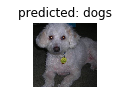

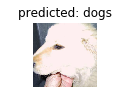

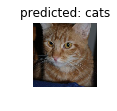

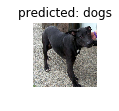

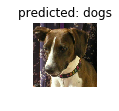

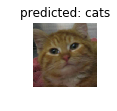

In [16]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [17]:
# Note that this way of copying files will generate outputs.
"""
%mkdir -p data/train
%mkdir -p data/val
%mkdir -p /tmp/.torch/models

%cp -r ../input/dogs-vs-cats/dataset/dataset/training_set/* data/train
%cp -r ../input/dogs-vs-cats/dataset/dataset/test_set/* data/val
%cp -r ../input/pretrained-pytorch-models/* /tmp/.torch/models

import os
print(os.listdir("data"))
print(os.listdir("/tmp/.torch/models"))
"""

'\n%mkdir -p data/train\n%mkdir -p data/val\n%mkdir -p /tmp/.torch/models\n\n%cp -r ../input/dogs-vs-cats/dataset/dataset/training_set/* data/train\n%cp -r ../input/dogs-vs-cats/dataset/dataset/test_set/* data/val\n%cp -r ../input/pretrained-pytorch-models/* /tmp/.torch/models\n\nimport os\nprint(os.listdir("data"))\nprint(os.listdir("/tmp/.torch/models"))\n'